In [1]:
'''
虽然这是不经济的，但是还是搬用这个方法试一试，这是你现在手里能找到的唯一的方法了。
'''

'\n虽然这是不经济的，但是还是搬用这个方法试一试，这是你现在手里能找到的唯一的方法了。\n'

In [1]:
import os
import numpy as np
import mne
from mne.event import define_target_events
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from neurora import rsa_plot
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm
from neurora.rsa_plot import plot_corrs_by_time
from scipy.interpolate import interp1d
from neurora.rsa_plot import plot_corrs_hotmap
# from window_slider import Slider
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap

from typing import Dict, Tuple, List


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import signal
from nilearn import plotting, datasets, surface
import nibabel as nib
from neurora.stuff import get_affine, correct_by_threshold, get_bg_ch2, get_bg_ch2bet



In [2]:
"""
因为每个被试都要单独保持生成两个dissimilarity矩阵，
所以不能像原来那样粗暴地复制了，不划算，需要改写函数。
参数有哪些呢：
1 被试编号
全局变量给一个list
"""
#'用来存放dissimilarity（T1分散 VS T2分散） '
LIST_spaced = []
#'用来存放dissimilarity（T1分散 VS T2集中） '
LIST_massed = []

In [3]:
def eegdataOfOneField(channel_fieldn, epoch1, epoch2):
    """
    作者：LYW

    功能：从全脑数据中拿出来某个区域的数据

    变量：把这个field对应的channel组成的string list传进来

    返回值：crop好的eegdata

    """
    epock1_fieldn = epoch1.copy().pick_channels(channel_fieldn)  # 加copy是因为会在自身修改。
    epock2_fieldn = epoch2.copy().pick_channels(channel_fieldn)
    num_chan_picked = len(channel_fieldn)
    '''进行这两个条件之间STPS的计算'''
    # shape of eegdate: [n_cons, n_subs, n_chls, n_ts]
    eegdata = np.zeros([2, 1, num_chan_picked, 501], dtype=np.float32)
    # 把T1 T2合并起来，但是是建立一个新的维度：conditions，并不是直接拼接到一起。
    # 所以事先定好结构，然后赋值进去
    eegdata[0] = epock1_fieldn.data
    eegdata[1] = epock2_fieldn.data
    # 为了使用RSA函数，增加一个维度trial维度，两种condition下都只有一个trail（evoked）
    eegdata = np.reshape(eegdata, [2, 1, 1, num_chan_picked, 501])

    return eegdata

def OneLineOfSTPS(eegdata):
    """
    :arg:把evoked数据根据时间切块，每一个时间块都有对应的一个RSA，然后取RSA矩阵中的cell，作为这行STPS的值。
    :param eegdata: 2个条件下的eegdata,是
    :return: 只是十个值组成的一行的STPS
    """
    # 构造STPSrdm,分成10段
    OneLineOf_STPS = np.zeros([1, 450], dtype=np.float32)
    m = 0
    for m in range(450):
        n = m + 1
        ndarray = eegdata
        #用这个函数间接地求了矩阵之间的 差异值才对 Representational Dissimilarity Matrix
        rdm = eegRDM(ndarray[:, :, :, :, n:n + 50])
        OneLineOf_STPS[0, m] = rdm[0, 1]
    return OneLineOf_STPS


In [6]:
#去掉了 5和9被试
T1_sub_ids = [
            'pre8M001', 'pre8M002', 'pre8M003', 'pre8M005','pre8M006', ]
#去掉了 5和9被试
T2M_sub_ids = [
            'pre8M001M', 'pre8M002M', 'pre8M003M' , 'pre8M005M','pre8M006M',  ]

T2S_sub_ids = [
            'pre8M001S','pre8M002S', 'pre8M003S' , 'pre8M005S','pre8M006S',  ]



T1_sub_ids = [
            'prex006S','prex009S','prex010S','prex011S','prex012S',
                        'prex015S','prex016S','prex017S','prex018S','prex019S','prex022S','prex023S',
                        'prex024S','prex026S','prex027S','prex028S','prex029S'
                        ,'prex033S','prex034S','prex037S','prex038S','prex039S'
                        ,'prex041S','prex042S','prex043S','prex044S','prex045S']
#去掉了 5和9被试
T2M_sub_ids = [
            'prex006M','prex009M','prex010M','prex011M','prex012M',
            'prex015M','prex016M','prex017M','prex018M','prex019M','prex022M','prex023M',
            'prex024M','prex026M','prex027M','prex028M','prex029M'
            ,'prex033M','prex034M','prex037M','prex038M','prex039M'
             ,'prex041M','prex042M','prex043M','prex044M','prex045M']

T2S_sub_ids = [
            'prex006','prex009','prex010','prex011','prex012',
                        'prex015','prex016','prex017','prex018','prex019','prex022','prex023',
                        'prex024','prex026','prex027','prex028','prex029'
                        ,'prex033','prex034','prex037','prex038','prex039',
                        'prex041','prex042','prex043','prex044','prex045'
            ]





T1_sub_ids = [

                        'prex015S','prex016S','prex018S','prex019S','prex022S','prex023S',
                        'prex026S','prex027S','prex028S'
                        ,'prex033S','prex034S','prex037S','prex038S','prex039S'
                        ,'prex042S','prex043S','prex044S','prex045S','prex046S','prex047S','prex048S','prex049S','prex052S']
#去掉了 5和9被试
T2M_sub_ids = [
            'prex006M','prex009M','prex010M','prex011M','prex012M',
            'prex015M','prex016M','prex017M','prex018M','prex019M','prex022M','prex023M',
            'prex026M','prex027M','prex028M'
            ,'prex033M','prex034M','prex037M','prex038M','prex039M'
             ,'prex041M','prex042M','prex043M','prex044M','prex045M','prex046M','prex047M','prex048M','prex049M','prex052M']

T2S_sub_ids = [
            'prex006','prex009','prex010','prex011','prex012',
                        'prex015','prex016','prex017','prex018','prex019','prex022','prex023',
                        'prex026','prex027','prex028'
                        ,'prex033','prex034','prex037','prex038','prex039',
                        'prex041','prex042','prex043','prex044','prex045','prex046','prex047','prex048','prex049','prex052'
            ]

# T1_sub_ids = [
#             'prex029']
#
# T2M_sub_ids = [
#             'prex029M']
# T2S_sub_ids = [
#             'prex029S']

data_path = 'E:\Python LYW\RSA\spaced_learning\pre10\\analysis\\data\\7evoked\\'

list_evoked_T1S = list()
list_evoked_T2S = list()
list_evoked_T2M = list()

for sub_id in T1_sub_ids:
    fname = data_path + sub_id + '-ave.fif'
    evoked = mne.read_evokeds(fname)[0]
    list_evoked_T1S.append(evoked)

for sub_id in T2S_sub_ids:
    fname = data_path + sub_id + '-ave.fif'
    evoked = mne.read_evokeds(fname)[0]
    list_evoked_T2S.append(evoked)

for sub_id in T2M_sub_ids:
    fname = data_path + sub_id + '-ave.fif'
    evoked = mne.read_evokeds(fname)[0]
    list_evoked_T2M.append(evoked)


Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\7evoked\prex015S-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms (103)
        0 CTF compensation matrices available
        nave = 46 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\7evoked\prex016S-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms (103)
        0 CTF compensation matrices available
        nave = 49 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
No baseline correction applied
Reading E:\Python LYW\RSA\spaced_learning\pre10\analysis\data\7evoked\prex018S-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms (103)
        0 CTF compensation matrices available
        nave = 44 - aspect type = 100
No project

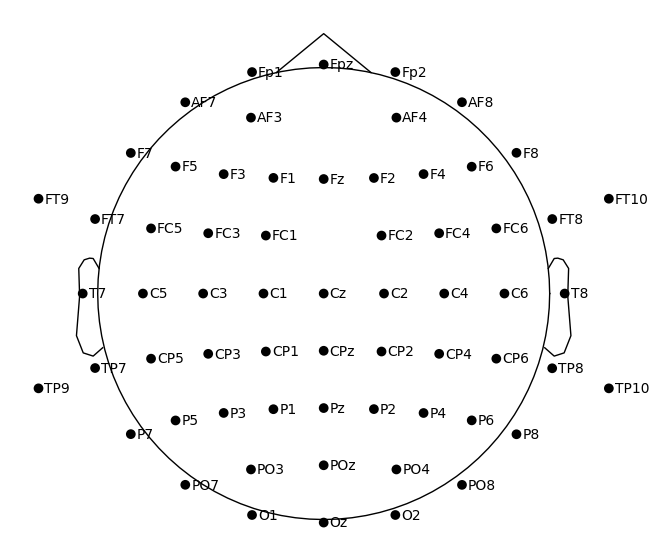

In [7]:
%matplotlib qt
evoked.plot_sensors(show_names=True)

In [8]:
#时间长。。
#每个field给13个field
#你的时间范围应该是从-0.2到0.8
field_dict = {
        #去掉AFz POz FCz CPz
        #本质只是缺了一个AFz，先用别的替代着？
        "channel_field1": ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'TP9', 'TP10', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'Oz'],

    }

for i in range(len(T1_sub_ids)):
    T1S = list_evoked_T1S[i]
    T2S = list_evoked_T2S[i]
    T2M = list_evoked_T2M[i]
    #每个被试都要生成两个rdm
    STPSrdm_T1S_T2S = np.zeros([1, 450], dtype=np.float32)
    for m in range(1):
        channel_fieldn = field_dict["channel_field" + str(m + 1)]
        eegdataOfOnefield = eegdataOfOneField(channel_fieldn,T1S, T2S)
        OneLineOf_STPS = OneLineOfSTPS(eegdataOfOnefield)
        STPSrdm_T1S_T2S[m, :] = OneLineOf_STPS
    LIST_spaced.append(STPSrdm_T1S_T2S)


    STPSrdm_T1S_T2M = np.zeros([1, 450], dtype=np.float32)
    for m in range(1):
        channel_fieldn = field_dict["channel_field" + str(m + 1)]
        eegdataOfOnefield = eegdataOfOneField(channel_fieldn, T1S, T2M)
        OneLineOf_STPS = OneLineOfSTPS(eegdataOfOnefield)
        STPSrdm_T1S_T2M[m, :] = OneLineOf_STPS
    LIST_massed.append(STPSrdm_T1S_T2M)


Computing RDMs

RDMs computing finished!


ValueError: setting an array element with a sequence.

In [ ]:
#先做单个位置的数据提取，然后t检验，然后再循环每个位置，做两重循环了
#所有被试，某行某列。t值，p值。。一个是显著性，一个是大小。
from scipy import stats
nps = np.zeros([1, 450, 2])
for m in range(1):
    for n in range(450):
        k1 = []
        k1.append(LIST_spaced[i][m][n])
        k2 = []
        for i in range(len(T2M_sub_ids)):
            k2.append(LIST_massed[i][m][n])
        # (static,p1) = stats.levene(k1,k2)
        # nps[m, n] = stats.ttest_ind(k1, k2)
        nps[m, n] = stats.ttest_rel(k1, k2)

#去掉baseline部分
nps2 = np.zeros([1, 400, 2])
nps2 = nps[:, 100:450, :]

In [ ]:
#热图，不带轮廓
# plot_nps_hotmap(nps2[:, :, 0], lim=[-2,2], time_unit=[0, 0.002])

In [ ]:
plt.clf()
def plot_stats_hotmap(stats, chllabels='', p_threshold=0.05, time_unit=[0, 0.02], lim=[-7, 7], smooth=False, figsize=None, cmap=None, outline=False, threshold=5):
    """
    plot the hotmap of statistical results for channels/regions by time sequence

    stats : array
        The statistical results.
        The shape of stats must be [n_chls, ts, 2]. n_chls represents the number of channels or regions.
        ts represents the number of time-points. 2 represents a t-value and a p-value.
    chllabel : string-array or string-list or None. Default is None.
        The label for channels/regions.
        If label=None, the labels will be '1st', '2nd', '3th', '4th', ... automatically.
    time_unit : array or list [start_t, t_step]. Default is [0, 0.1]
        The time information of corrs for plotting
        start_t represents the start time and t_step represents the time between two adjacent time-points. Default
        time_unit=[0, 0.1], which means the start time of corrs is 0 sec and the time step is 0.1 sec.
    lim : array or list [min, max]. Default is [-7, -7].
        The corrs view lims.
    smooth : boolean True or False
        Smooth the results or not.
    figsize : array or list, [size_X, size_Y]
        The size of the figure.
        If figsize=None, the size of the figure will be ajusted automatically.
    cmap : matplotlib colormap or None. Default is None.
        The colormap for the figure.
        If cmap=None, the ccolormap will be 'bwr'.
    outline : bool True or False. Default is False.
        Outline the significant areas or not.
    threshold: int. Default is 5.
        The time threshold for outline.
        If threshold=5, the time threshold is a window of 5 time-points for each channel/region.
    """

    # get the number of channels
    nchls = stats.shape[0]

    # get the number of time-points
    ts = stats.shape[1]

    # get the start time and the time step
    start_t = time_unit[0]
    tstep = time_unit[1]

    # calculate the end time
    end_t = start_t + ts * tstep

    print(start_t, tstep, end_t)

    # initialize the x
    x = np.arange(start_t, end_t, tstep)

    # set labels of the channels
    if chllabels == None:

        chllabels = []
        for i in range(nchls):

            if i % 10 == 0 and i != 10:
                newlabel = str(i + 1) + "st"
            elif i % 10 == 1 and i != 11:
                newlabel = str(i + 1) + "nd"
            elif i % 10 == 2 and i != 12:
                newlabel = str(i + 1) + "rd"
            else:
                newlabel = str(i + 1) + "th"
            chllabels.append(newlabel)

    if smooth == True:

        t = ts * 50

        x_soft = np.linspace(x.min(), x.max(), t)
        y_soft = np.zeros([nchls, t])

        samplerate = int(1 / tstep) * 50
        b, a = signal.butter(4, 2*30/samplerate, 'lowpass')

        for i in range(nchls):
            f = interp1d(x, stats[i, :, 0], kind='cubic')
            y_soft[i] = f(x_soft)
            y_soft[i] = signal.filtfilt(b, a, y_soft[i])

        rlts = y_soft

    if smooth == False:
        rlts = stats[:, :, 0]

    print(rlts.shape)

    # get min of lims & max of lims
    limmin = lim[0]
    limmax = lim[1]

    if outline == True:
        ps = stats[:, :, 1]
        tvalues = stats[:, :, 0]

        for i in range(nchls):
            for j in range(ts):

                if ps[i, j] < p_threshold and tvalues[i, j] > 0:
                    ps[i, j] = 1
                elif ps[i, j] < p_threshold and tvalues[i, j] < 0:
                    ps[i, j] = -1
                else:
                    ps[i, j] = 0

        for i in range(nchls):
            pid = set(())
            for j in range(ts):
                if ps[i, j] != 0:
                    pid.add(j)
            pid_list = list(pid)
            pid_list.sort()
            pid_set = set()
            for j in pid_list:
                index = 0
                for k in range(threshold):
                    if j+k in pid_list:
                        index = index
                    else:
                        index = index + 1
                if index == 0:
                    for k in range(threshold):
                        pid_set.add(j+k)
            pid_list = list(pid_set)
            pid_list.sort()
            for j in range(ts):
                index = j in pid_list
                if index is False:
                    ps[i, j] = 0

        newps = np.zeros([nchls+2, ts+2], dtype=np.float)
        newps[1:nchls+1, 1:ts+1] = ps

        x = np.linspace(start_t-0.5*tstep, end_t+0.5*tstep, ts+2)
        y = np.linspace(-0.08, 0.16*nchls+0.08, nchls+2)
        X, Y = np.meshgrid(x, y)
        plt.contour(X, Y, newps, (-0.5, 0.5), linewidths=3)

    fig = plt.gcf()
    size = fig.get_size_inches()

    if figsize == None:
        size_x = ts*tstep*(size[0]-2)+2
        size_y = nchls*0.2*(size[1]-1.5)+1.5
    else:
        size_x = figsize[0]
        size_y = figsize[1]

    fig.set_size_inches(size_x, size_y)

    if cmap == None:
        plt.imshow(rlts, extent=(start_t, end_t, 0, nchls*0.16), clim=(limmin, limmax), origin='low')
    else:
        plt.imshow(rlts, extent=(start_t, end_t, 0, nchls * 0.16), clim=(limmin, limmax), origin='low', cmap=cmap)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=16)
    font = {'size': 18}
    cb.set_label("Dissimilarity", fontdict=font)

    xi = []

    for i in range(nchls):
        xi.append(0.16*i + 0.08)

    yi = chllabels

    plt.tick_params(labelsize=18)
    plt.yticks(xi, yi, fontsize=18)

    plt.ylabel("wholebrain", fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)

    plt.show()

#调用，设定threshold=5
plot_stats_hotmap(nps2, time_unit=[0, 0.002],lim=[-2,2], smooth=True, threshold=5 ,outline=True, cmap = "pink" )



In [ ]:
#如果想要画出线性的图呢？另一种呈现方式？但是你对比的是哪两个啊？画出来的是t值的均值？
#把求t改成求平均值就能得到你想要的两个  一维 数据了。
#分别装到两个 一维 向量里面

# 一维数据存储均值就行
#1是T1 vs T2S
ave1 = np.zeros([1, 350])
ave2 = np.zeros([1, 350])
for m in range(1):
    for n in range(100,450):
        k1 = []
        for i in range(len(T2S_sub_ids)):
            #从rdm里面取出想要的差异值
            k1.append(LIST_spaced[i][m][n])
        k2 = []
        for i in range(len(T2M_sub_ids)):
            k2.append(LIST_massed[i][m][n])
        # (static,p1) = stats.levene(k1,k2)
        # nps[m, n] = stats.ttest_ind(k1, k2)
        # nps[m, n] = stats.ttest_rel(k1, k2)
        ave1[m, n-100]= np.mean(k1)
        ave2[m, n-100]= np.mean(k2)

In [ ]:
#作图
#这里是差异值，dissimilarity
# 单个被试分析的时候就可以考虑用这个来看看，因为不能进行统计。
plt.clf()
x = range(len(ave1))

plt.plot(ave1[0,:], 'g')
plt.plot(ave2[0,:], 'b')
plt.show()


In [ ]:
'''
直接画 nps2 的看看
画什么呢？画p值，还是画t值
'''

x = np.linspace(0, 0.7, 350)
plt.plot(x, nps2[0,:,0])


In [ ]:
#和上面无关，临时用来输出channels给使用。

save_file = open('./channels.txt', 'w')
for channel_name in evoked.ch_names:
    save_file.write(channel_name)
    save_file.write('\n')
save_file.close()
